# 3. Creating Muscle-driven Simulations with OpenSim Moco


## 3.1. Objectives

[OpenSim Moco](https://opensim-org.github.io/opensim-moco-site/) is a software package for creating musculoskeletal simulations using trajectory optimization [[1]](https://doi.org/10.1371/journal.pcbi.1008493). Users define problems by providing an OpenSim model, cost function terms, and additional problem constraints via an easy-to-use scripting interface. Moco employs the state-of-the-art direct collocation method to rapidly solve trajectory optimization problems.

**Purpose**

The purpose of this tutorial is to introduce users to Moco via the [Conda OpenSim](https://anaconda.org/opensim-org/opensim) and [Jupyter notebooks](https://jupyter.org/). In this tutorial you will:

*   Solve a standalone "sliding mass" problem with OpenSim Moco.
*   Visualize the position of the pendulum using [matplotlib](https://matplotlib.org/).

## 3.2. Set up Conda and OpenSim

In the following cell, you will use [condacolab](https://github.com/conda-incubator/condacolab) to install [Miniconda](https://docs.conda.io/en/latest/miniconda.html). If you want to install a different conda distribution (e.g., Anaconda, Mambaforge) check [condacolab's documentation](https://github.com/conda-incubator/condacolab#usage).

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Don't worry if after executing the previous cell you get an error saying that your session has failed. The reason for this is that condacolab needs to restart the session for the changes to take effect. Because of this, you have to execute the previous cell first, before executing any other cell.

Now, execute the following cell to install the OpenSim conda package using conda.

In [ ]:
!conda install opensim_admin::opensim-moco

## 3.3. Solve the "sliding mass" problem


The following cell imports the OpenSim module and, if successful, shows the current version and build date (**should be 4.5**).

In [7]:
import os
import opensim as osim
osim.GetVersionAndDate()

'version 4.5-2023-11-26-efcdfd3eb, build date 23:19:12 Nov 28 2023'

In [3]:
model = osim.Model()
model.setName('sliding_mass')
model.set_gravity(osim.Vec3(0, 0, 0))
body = osim.Body('body', 2.0, osim.Vec3(0), osim.Inertia(0))
model.addComponent(body)

# Allows translation along x.
joint = osim.SliderJoint('slider', model.getGround(), body)
coord = joint.updCoordinate()
coord.setName('position')
model.addComponent(joint)

actu = osim.CoordinateActuator()
actu.setCoordinate(coord)
actu.setName('actuator')
actu.setOptimalForce(1)
model.addComponent(actu)

body.attachGeometry(osim.Sphere(0.05))

model.finalizeConnections()

# Create MocoStudy.
# ================
study = osim.MocoStudy()
study.setName('sliding_mass')

# Define the optimal control problem.
# ===================================
problem = study.updProblem()

# Model (dynamics).
# -----------------
problem.setModel(model)

# Bounds.
# -------
# Initial time must be 0, final time can be within [0, 5].
problem.setTimeBounds(osim.MocoInitialBounds(0.), osim.MocoFinalBounds(0., 5.))

# Position must be within [-5, 5] throughout the motion.
# Initial position must be 0, final position must be 1.
problem.setStateInfo('/slider/position/value', osim.MocoBounds(-5, 5),
                     osim.MocoInitialBounds(0), osim.MocoFinalBounds(1))
# Speed must be within [-50, 50] throughout the motion.
# Initial and final speed must be 0. Use compact syntax.
problem.setStateInfo('/slider/position/speed', [-50, 50], [0], [0])

# Applied force must be between -50 and 50.
problem.setControlInfo('/actuator', osim.MocoBounds(-50, 50))

# Cost.
# -----
problem.addGoal(osim.MocoFinalTimeGoal())

# Configure the solver.
# =====================
solver = study.initCasADiSolver()
solver.set_num_mesh_intervals(100)

# Now that we've finished setting up the study, print it to a file.
study.printToXML('sliding_mass.omoco')

# Solve the problem.
# ==================
solution = study.solve()

solution.write('sliding_mass_solution.sto')

## TODO visualize the solution

You should now have a sliding_mass_solution.sto in your files.

## 3.3. Fit function-based paths for the "squat-to-stand" model 

Use forward integration to create a random trajectory that we can use as a reference when fitting polynomial functions to represent muscle lengths. 

In [4]:
model = osim.Model('squatToStand_3dof9musc.osim')
state = model.initSystem()
manager = osim.Manager(model, state)
manager.integrate(2.0)
table = manager.getStatesTable()
sto = osim.STOFileAdapter()
sto.write(table, 'reference_states.sto')

Now use `PolynomialPathFitter` to randomly sample coordinate values around the reference trajectory. First,muscle lengths and moment arms will be computed from the sampled coordinate values. Coefficients for multivariate polynomial functions representing the muscle lengths are determined using a least-squares fit. Both the muscle lengths and the moment arms (via the polynomial derivatives) are included in the fitting process. 

In [6]:
fitter = osim.PolynomialPathFitter()
fitter.setModel(osim.ModelProcessor(model))
times = table.getIndependentColumn()
# TODO avoid this with the latest OpenSim API.
for i in reversed(range(len(times))):
    table.setIndependentValueAtIndex(i, i)
for i in range(len(times)):
    if i % 5 != 0:
        table.removeRow(i)
fitter.setCoordinateValues(osim.TableProcessor(table))
fitter.setMaximumPolynomialOrder(5)
fitter.setNumSamplesPerFrame(15)
fitter.setGlobalCoordinateSamplingBounds(osim.Vec2(-50, 50))
# TODO include this when the API is updated.
# fitter.setUseStepwiseRegression(True)
fitter.setPathLengthTolerance(1e-3)
fitter.setMomentArmTolerance(1e-3)
fitter.setOutputDirectory('path_fitting')
fitter.run()

Now, plot the results.

('/forceset/bifemsh_r_length', '/forceset/med_gas_r_length', '/forceset/glut_max2_r_length', '/forceset/psoas_r_length', '/forceset/rect_fem_r_length', '/forceset/semimem_r_length', '/forceset/soleus_r_length', '/forceset/tib_ant_r_length', '/forceset/vas_int_r_length')


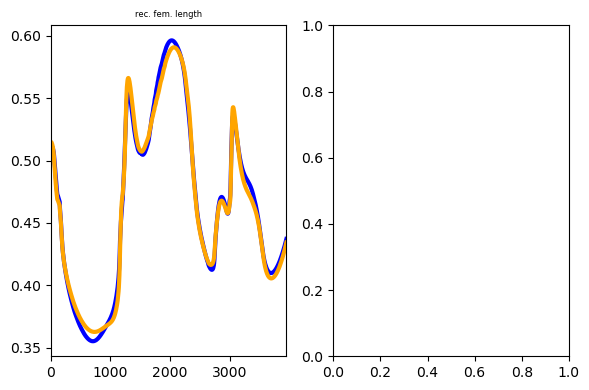

In [19]:
import numpy as np
from matplotlib import pyplot as plt

lengths = osim.TimeSeriesTable(
    os.path.join('path_fitting', 'squatToStand_path_lengths.sto'))
print(lengths.getColumnLabels())

lengthsFitted = osim.TimeSeriesTable(
    os.path.join('path_fitting', 'squatToStand_path_lengths_fitted.sto'))

fig, axs = plt.subplots(1, 2, figsize=(6, 4))

times = lengths.getIndependentColumn()
axs[0].plot(times,
    lengths.getDependentColumn('/forceset/rect_fem_r_length').to_numpy(),
    lw=3, color='blue')
axs[0].set_xlim(times[0], times[-1])
axs[0].set_title('rec. fem. length', fontsize=6)

times = lengthsFitted.getIndependentColumn()
axs[0].plot(times,
    lengthsFitted.getDependentColumn('/forceset/rect_fem_r_length').to_numpy(),
    lw=3, color='orange')
axs[0].set_xlim(times[0], times[-1])
axs[0].set_title('rec. fem. length', fontsize=6)

fig.tight_layout()
plt.show()

In [8]:
modelProcessor = osim.ModelProcessor('squatToStand_3dof9musc.osim')
modelProcessor.append(osim.ModOpReplaceMusclesWithDeGrooteFregly2016())
modelProcessor.append(osim.ModOpIgnorePassiveFiberForcesDGF())
modelProcessor.append(osim.ModOpScaleMaxIsometricForce(2.0))
modelProcessor.append(osim.ModOpScaleActiveFiberForceCurveWidthDGF(1.5))
modelProcessor.append(osim.ModOpReplacePathsWithFunctionBasedPaths(
    os.path.join('path_fitting', 'squatToStand_FunctionBasedPathSet.xml')))

<opensim.actuators.ModelProcessor; proxy of <Swig Object of type 'OpenSim::ModelProcessor *' at 0x000001C628ACE7C0> >

## 3.X. Conclusion

In this tutorial you used [condacolab](https://github.com/conda-incubator/condacolab) to install [Miniconda](https://docs.conda.io/en/latest/miniconda.html) in [Google Colab](https://colab.research.google.com/?hl=en). Then, you  installed Conda [OpenSim](https://opensim.stanford.edu/) in the Miniconda environment, and you tested it by creating and simulating a simple pendulum and simulating. Finally, you plotted the positions of the pendulum using [matplotlib](https://matplotlib.org/).

## 3.X. Useful Links





> **OpenSim Website:** https://opensim.stanford.edu/
>
> **OpenSim API Documentation:** https://simtk.org/api_docs/opensim/api_docs/
>
> **OpenSim Creator Website:** https://opensimcreator.com/
>
> **SimTK Website:** https://simtk.org/projects/opensim
>
> **Biomechanics of Movement Course Videos:** https://www.youtube.com/channel/UCDNGy0KKNLQ-ztcL5h2Z6zA

## 3.X Acknowledgments

Thanks to [OpenSimColab](https://simtk.org/projects/opencolab) project [[2]](https://doi.org/10.1080/10255842.2022.2104607) for creating the first OpenSim Conda package.

## 3.X. References




> [1] Dembia CL, Bianco NA, Falisse A, Hicks JL, Delp SL (2020) OpenSim Moco: Musculoskeletal optimal control. PLOS Computational Biology 16(12): e1008493. https://doi.org/10.1371/journal.pcbi.1008493
>
> [2] Mokhtarzadeh, H., Jiang, F., Zhao, S., & Malekipour, F. (2022). **OpenColab project: OpenSim in Google colaboratory to explore biomechanics on the web.** *Computer Methods in Biomechanics and Biomedical Engineering*, 1–9. https://doi.org/10.1080/10255842.2022.2104607